In [76]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def euler_step(y, h, f, t):
    return y + h * f(y, t)

def symplectic_euler_step(y, h, f, t):
    p, q = y
    p_next = p + h * f(y, t)[0]
    q_next = q + h * f([p_next, q], t)[1]
    return np.array([p_next, q_next])

def solve(t0, tf, h, y0, sigma, f, N, Method):
    
    times = np.arange(t0, tf, h)
    Normal=sigma*h**(1/2)*np.random.normal(size=(len(y0), N, len(times[:-1])))
    
    y = np.tile(y0, (N, 1)).T
    
    if (Method=='EM'):
        for i in range(len(times[:-1])):
            y = euler_step(y, h, f, times[i])+Normal[:,  :, i]
    elif(Method=='SS'):
        for i in range(len(times[:-1])):
            y = symplectic_euler_step(y, h, f, times[i])+Normal[:,  :, i]
    
    return  y

def Diff(t0, tf, h, y0, sigma, f, N, Method):
    
    sol = solve(t0, tf, h, y0, sigma, f, N, Method)
    D=sol[0, :]**2/ (2*tf)
    return np.mean(D)


def plot_DE(sigma_values, D_values):
    # Compute the logarithms of sigma, D
    log_sigma = np.log(sigma_values)
    log_D = np.log(D_values)
    

    # Fit a linear function to log_DE vs log_sigma
    fit = np.polyfit(log_sigma, log_D, 1)

    # Compute the slope and intercept of the fitted line
    slope, intercept = fit[0], fit[1]

    # Plot log_D vs log_sigma and log_E vs log_sigma on a log-log scale
    plt.loglog(sigma_values, D_values, 'o', label='D')

    # Add the fitted line to the plot
    plt.loglog(sigma_values, np.exp(intercept) * sigma_values**slope, '-',
               label=f'log(D ) = {slope:.2f} log(σ) + {intercept:.2f}')

    # Add a legend and axis labels
    plt.legend()
    plt.xlabel('σ')
    plt.ylabel('D ')
    plt.show()


100%|██████████| 6/6 [00:00<00:00, 399.44it/s]


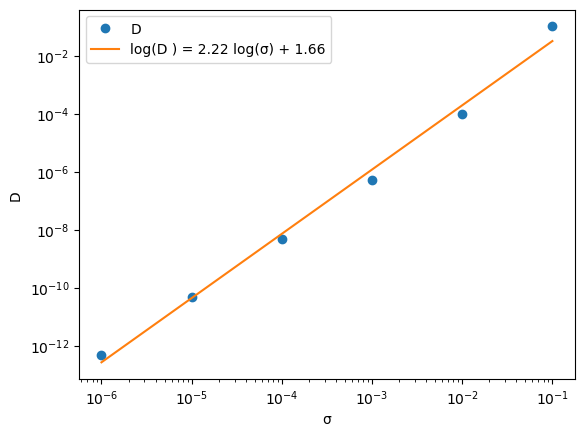

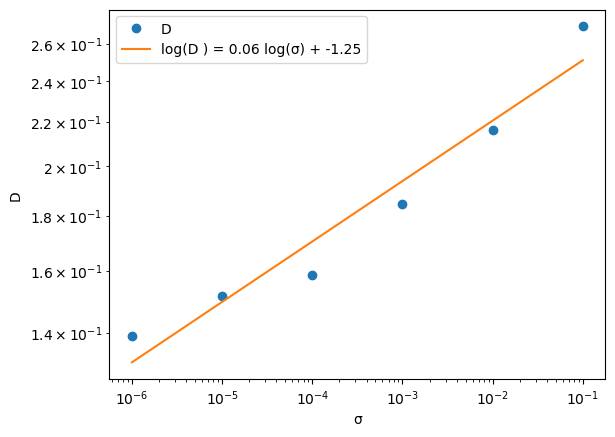

In [61]:
from joblib import Parallel, delayed

f = lambda y, t: np.array([-np.sin(y[1]), np.sin(y[0])])

t0, tf, h, y0,  N=0, 5000, 0.05, np.array([0,0]), 5000

sigma_values = np.array([1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])
D_values = np.zeros_like(sigma_values)


def compute_Diff(sigma, t0, tf, h, y0, f, N, Method):
    return Diff(t0, tf, h, y0, sigma, f, N, Method)

def compute_D_values(sigma_values, t0, tf, h, y0, f, N, Method):
    D_values = np.zeros(len(sigma_values))
    
    # Run the loop over sigma_values in parallel
    D_values = Parallel(n_jobs=-1)(delayed(compute_Diff)(sigma, t0, tf, h, y0, f, N, Method)
                                   for sigma in tqdm(sigma_values))
    
    return D_values



D_values_SS=compute_D_values(sigma_values, t0, tf, h, y0, f, N, Method='SS')
D_values_EM=compute_D_values(sigma_values, t0, tf, h, y0, f, N, Method='EM')

plot_DE(sigma_values, D_values_SS)
plot_DE(sigma_values, D_values_EM)

The results I have do not match up with the theoretical result. The Symplectic Splitting method though was better then the Euler_Maruyama method in preserving the structure and diffusitivity. For the SS method, I got D was more on order $\sigma^2$. Perhaps the reason is a bug in my code (though I don't see where), perhaps changing the inital condition, time step, or final T value will have my answer fall more in line with the theoretical result. Below I also plot the P-Q phase plane to see how our system behaves.

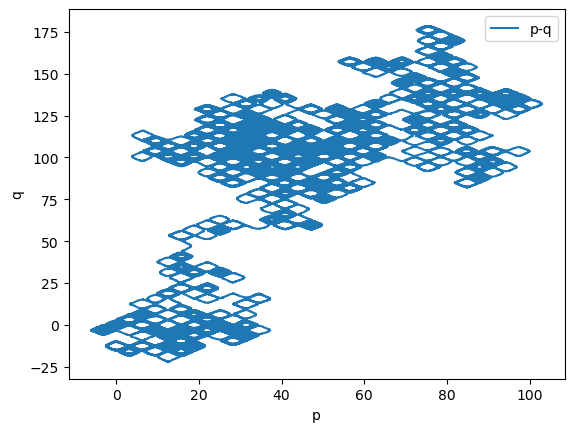

In [78]:
#plot the PQ plane for fun
def solve_path(t0, tf, h, y0, sigma, f, Method):
    
    times = np.arange(t0, tf, h)
    Normal=np.random.normal(size=(len(y0), len(times[:-1])))
    ys = np.zeros((len(times), len(y0)))
    
    ys[0,:] = y0

    if (Method=='EM'):
        for i in range(len(times[:-1])):
            ys[i+1,:] = euler_step(ys[i,:], h, f, times[i])+sigma*h**(1/2)*Normal[:, i]
    elif(Method=='SS'):
        for i in range(len(times[:-1])):
            ys[i+1,:] = symplectic_euler_step(ys[i,:], h, f, times[i])+sigma*h**(1/2)*Normal[:, i]
    return  ys

def plot_path(y):
    
    
    plt.plot(y[:, 1], y[:, 0], label='p-q')
    
    
    plt.xlabel('p')
    plt.ylabel('q')
    plt.legend()
    plt.show()


f = lambda y, t: np.array([-np.sin(y[1]), np.sin(y[0])])
t0, tf, h, y0=0, 50000, 0.01, np.array([0,0])

sol = solve_path(t0, tf, h, y0, .1, f, Method='SS')
plot_path( sol)
